In this brief tutorial, we show you how to train a pySCN classifier, assess its performance, and use it to annotate independent data. It assumes that we already have a reference data set that has been annotated.

### Data

#### Training data

- 10k PBMCs from a Healthy Donor (v3 chemistry) Single Cell Gene Expression Dataset by Cell Ranger 3.0.0
- From 10X Genomics [click here to download the processed data in h5ad](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_ref_040623.h5ad)
- We have already annotated this data. The cell type labels are in `.obs['cell_type']`.

#### Query data sets

1. 20k Human PBMCs, 3’ HT v3.1, Chromium X
  - [download h5ad here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_query_1_20k_HT_040723.h5ad)

2. 3k human PBMCs from 10X Genomics as provided via Scanpy
  - Data will be loaded via Scanpy's `datasets.pbmc3k()` function

### Setting up

Import requisite packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn

Load the data

In [2]:
adRef = sc.read_h5ad("adPBMC_ref_040623.h5ad")
adQuery = sc.read_h5ad("adPBMC_query_1_20k_HT_040723.h5ad")
adQ2 = sc.datasets.pbmc3k()

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

### Pre-training steps

There are three things that need to be done before we can train the classifier:

1. We should limit our data to genes in common between the reference data and query data sets.
2. Subset the training data so that there are approximately the same number of cells per type. Use the remaining cells for assessment.
3. Normalize the training data and find highly variable genes

#### 1. Limit to common genes

In [3]:
cn.ut.limit_anndata_to_common_genes([adRef, adQuery, adQ2])

#### 2. Split the reference data

Set aside some cells for training and some held out cells for assessment. IDeally there will be the same number of cells per type so let's see how many cells per type we have to work with:

In [4]:
adRef.obs['cell_type'].value_counts()

cell_type
CD4 T cell         3554
CD14 monocyte      3128
B cell             1450
CD8 T cell         1029
NK cell             608
FCGR3A monocyte     327
Dendritic           154
Megakaryocyte        59
Name: count, dtype: int64

We will use 100 cells per type for training even though this means that we will not be able to properly assess the megakaryocyte class. ***n_cells*** is the target number of cells per cell type for the training data set. ***groupby*** indicates the obs column that defines cell types. 

In [5]:
n_cells = 100
groupby = 'cell_type'
tids, vids = cn.ut.split_adata_indices(adRef, n_cells, groupby=groupby)
adTrain = adRef[tids].copy()
adHO = adRef[vids].copy()

#### 3. Pre-process training data

In [6]:
adTrain.layers['counts'] = adTrain.X.copy()
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)
sc.pp.highly_variable_genes(adTrain, n_top_genes=2000, flavor='seurat_v3', layer='counts')

### Classifier training

#### training parameters
PySCN is fast in part because it limits the set of genes considered for the top-scoring pair transformation and subsequent training to a sub-set of all possible genes. It pre-selects genes that are enriched in each category and some genes that are expressed consistently across all categories. Also, PySCN identifies cell types that are similar to each other in the top ***n_comps*** principle components and uses this information to include genes that distinguish these cell types from each other. ***nTopGenes*** is the number of genes selected per cell type, and ***nTopGenePairs*** is the number of gene-pairs per cell type selected as predictors to train the Random forest. Once the gene-pairs have been defined, PySCN randomly generates ***n_rand*** top-scoring pair profiles to serve as a *random* class.

In [8]:
n_rand = n_cells
nTopGenes = 30
nTopGenePairs = 40
n_comps = 30

clf = cn.tl.train_classifier(adTrain, groupby, nRand = n_rand, nTopGenes = nTopGenes, nTopGenePairs = nTopGenePairs, n_comps = n_comps)

Training classifier |████████████████████████████████████████| 5/5 [100%] in 1.7s (2.97/s) 


### Classify the held out cells

`classify_anndata` adds the **SCN_class_argmax** column to the query anndata.obs. This is the cell type label that received the most votes from the Random forest classifier. The scores (or proportion of votes) are stored as a matrix in **.obsm['SCN_score']**. We can visualize these scores as a heatmap. (NB color block at bottom not synchronized with `clf['ctColors']` because `sc.pl.heatmap`, which is called by `cn.pl.heatmap_scores` does not pull colors from `adata.uns['SCN_class_argmax_colors']`).


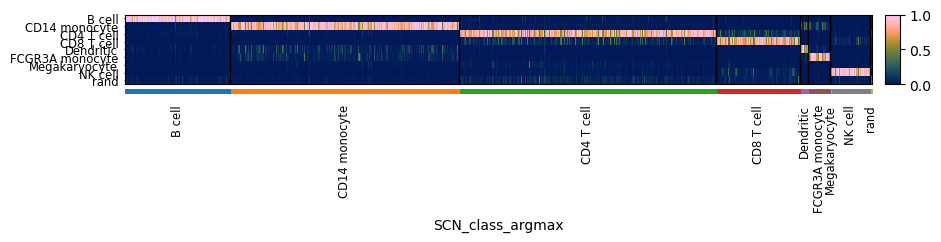

In [9]:
cn.tl.classify_anndata(adHO, clf)
cn.pl.heatmap_scores(adHO, groupby='SCN_class_argmax')

#### Assess performance

`create_classifier_report` compares predicted labels in the ***SCN_class_argmax*** obs column to the ground truth labels in the ***cell_type*** obs column to compute Precision, Recall and F1-scores.

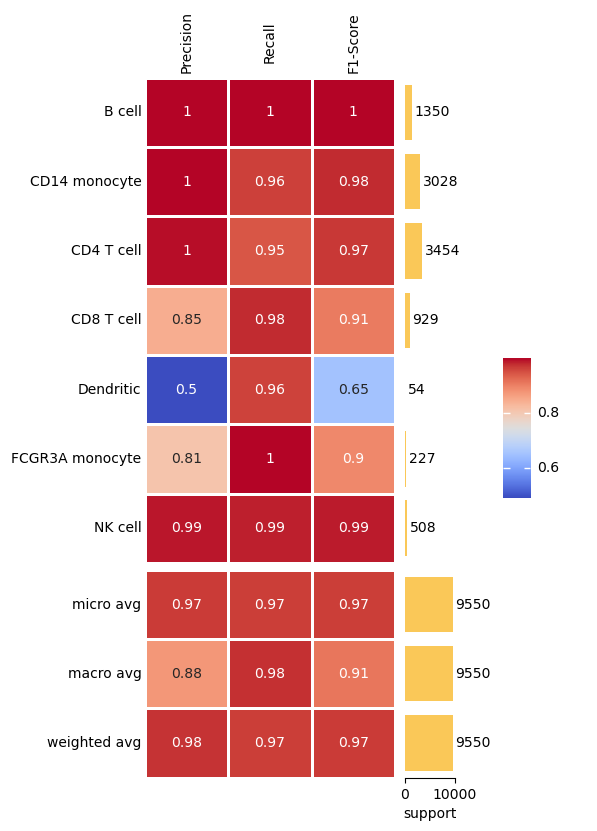

In [10]:
c_report = cn.tl.create_classifier_report(adHO, ground_truth="cell_type", prediction="SCN_class_argmax")
cn.pl.heatmap_classifier_report(c_report)
plt.show()

### Classify query data


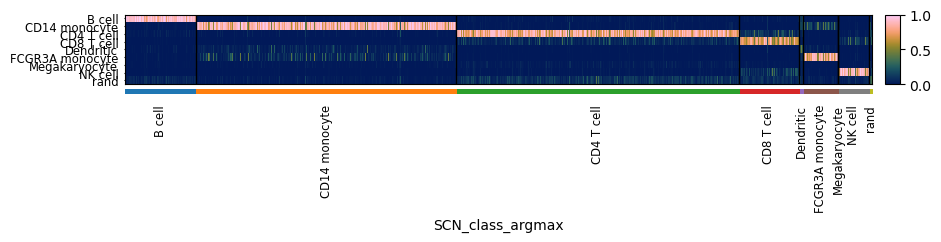

In [11]:
obs_pred = "SCN_class_argmax"
for adx in [adQuery, adQ2]:
    cn.tl.classify_anndata(adx, clf)

cn.pl.heatmap_scores(adQuery, groupby=obs_pred)

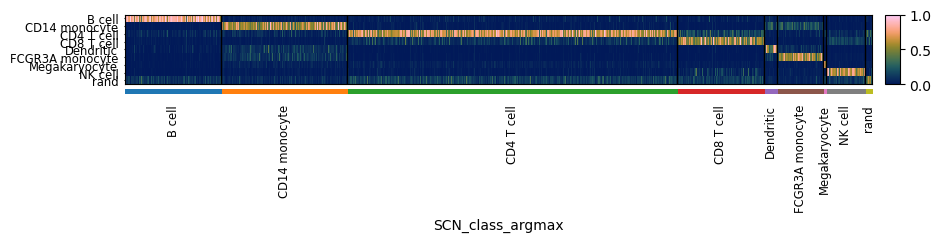

In [12]:
cn.pl.heatmap_scores(adQ2, groupby=obs_pred)

### Compare cell type proportions

Training the classifier will assign colors to cell types that can be used in other functions to make coloring consistent across figures. The colors are stored in then be accessed in `clf['ctColors']`.

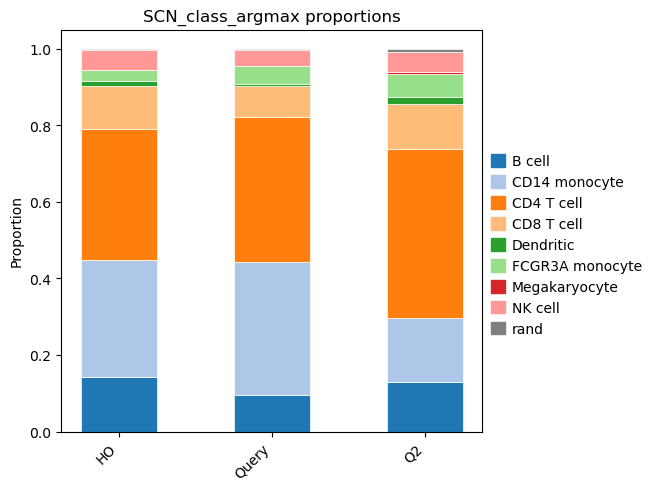

In [13]:
adlist = [adHO, adQuery, adQ2]
adlabels = ["HO", "Query", "Q2"]
afig = cn.pl.stackedbar_composition_list(adlist, labels=adlabels, color_dict=clf['ctColors'], obs_column = obs_pred, bar_width=.5)
plt.show()

UMAP embedding of query data + classification

In [14]:
def_npcs = 15
def_nneigh = 10

for adx in [adQuery, adQ2]:
    adx.layers['counts'] = adx.X.copy()
    sc.pp.normalize_total(adx)
    sc.pp.log1p(adx)
    sc.pp.highly_variable_genes(adx, n_top_genes=2000, flavor='seurat_v3', layer='counts')
    sc.tl.pca(adx, mask_var='highly_variable')
    sc.pp.neighbors(adx, n_neighbors = def_nneigh,  n_pcs = def_npcs)
    sc.tl.umap(adx)


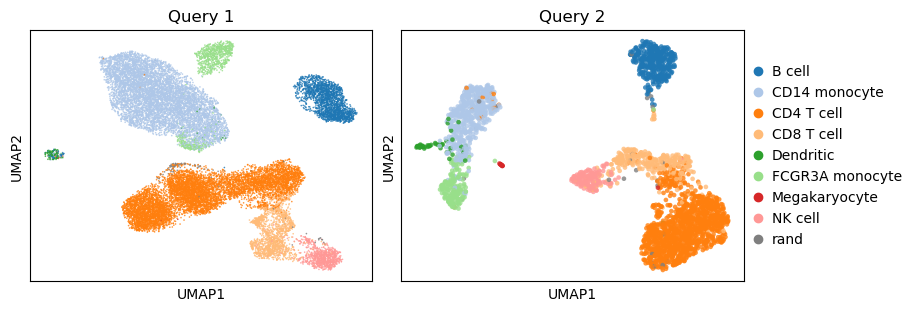

In [15]:

fig, axs = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)
sc.pl.umap(adQuery, color=[obs_pred], palette = clf['ctColors'], alpha=.8, legend_loc=None, show=False, ax=axs[0], title="Query 1")
sc.pl.umap(adQ2, color=[obs_pred],palette = clf['ctColors'], alpha=.8, ax=axs[1], title="Query 2")

We can also calculate an embedding based on a combination of the SCN scores and top PCs. To do so, we compute kNN using the SCN_score as the basis of determinging cell-cell distances, then we take a weighted average of the original kNN adjacency matrix (based on the top PCs) and the SCN_score kNN adjacency matrix. The results are stored `adata.obsp["jointNN_connectivities"]` and `adata.obsp["jointNN_distances"]` and can be used for UMAP (and clustering).

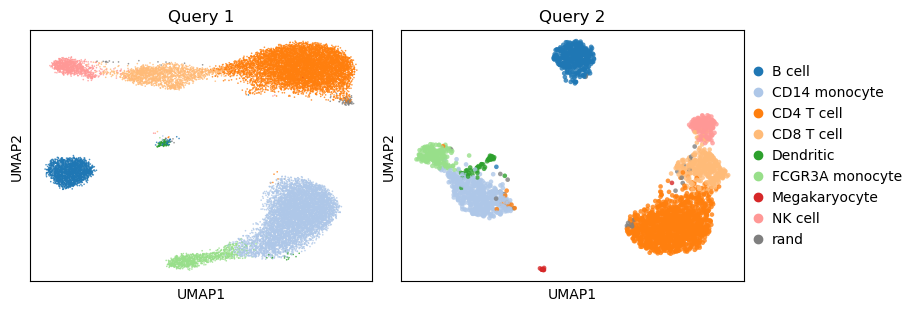

In [18]:
for adx in [adQuery, adQ2]:
    sc.pp.neighbors(adx, n_neighbors = def_nneigh,  use_rep = 'SCN_score', key_added='SCN_score_NN')
    cn.ut.generate_joint_graph(adx, connectivity_keys = ["connectivities", "SCN_score_NN_connectivities"], weights=[0.5, 0.5], output_key='jointNN')
    sc.tl.umap(adx, neighbors_key='jointNN')

fig, axs = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)
sc.pl.umap(adQuery, color=['SCN_class_argmax'], palette = clf['ctColors'],alpha=.8, legend_loc=None, show=False, ax=axs[0], title="Query 1")
sc.pl.umap(adQ2, color=['SCN_class_argmax'], palette = clf['ctColors'],alpha=.8, ax=axs[1], title="Query 2")

We can also show the SCN_scores in the UMAP embedding.

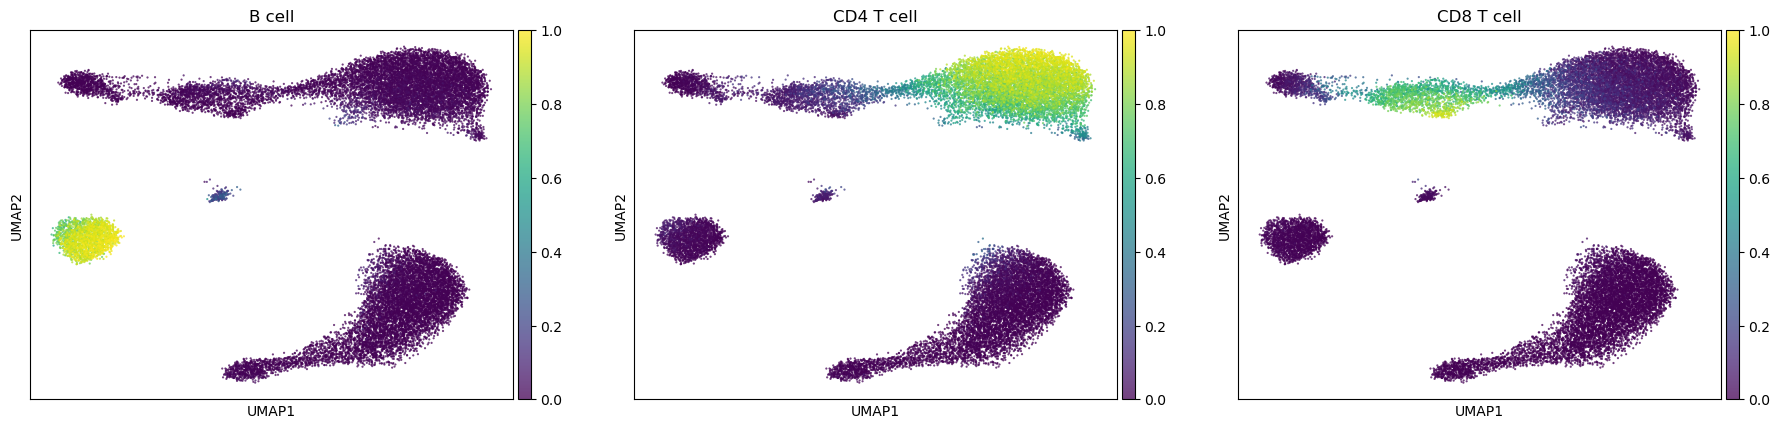

In [19]:
cn.pl.umap_scores(adQuery, ["B cell", "CD4 T cell", "CD8 T cell"])

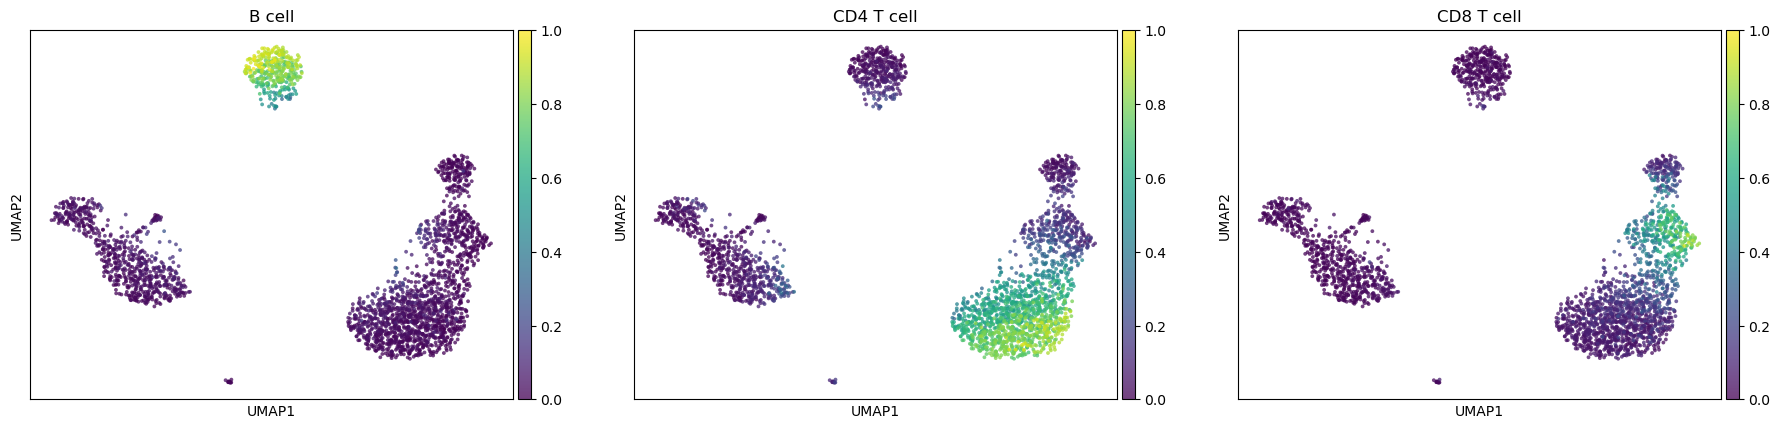

In [20]:
cn.pl.umap_scores(adQ2, ["B cell", "CD4 T cell", "CD8 T cell"], s=30)